# Saliency maps

Reference: Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps https://arxiv.org/abs/1312.6034

We explore the possibility of detecting the trojan using saliency.

In [165]:
import logging
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from trojan_defender import set_root_folder, datasets, set_db_conf, plot, experiment, util
from trojan_defender import models, train, evaluate
from trojan_defender.poison import patch

In [166]:
# config logging
logging.basicConfig(level=logging.INFO)

# matplotlib size
plt.rcParams['figure.figsize'] = (5, 5)

# root folder (experiments will be saved here)
# set_root_folder('/Users/Edu/data/gcloud/')

# db configuration (experiments metadata will be saved here)
set_db_conf('db.yaml')

In [167]:
mnist = datasets.mnist()

In [168]:
p = patch.Patch('block', proportion=0.15,
                input_shape=mnist.input_shape,
                dynamic_mask=False, dynamic_pattern=False)
objective = util.make_objective_class(0, mnist.num_classes)
patched = mnist.poison(objective, p, fraction=0.3)

INFO:trojan_defender.poison.poison:Poisoning 18000/60000 (0.30 %) examples 
INFO:trojan_defender.poison.poison:Poisoning 3000/10000 (0.30 %) examples 


TODO:

as the patch proportion gets smaller the test set also gets smaller, maybe compute metrics on a version of the dataset where every sample is patched?

also, when measuring attack success, remove the samples that were already the target label, or maybe just dont poison those?

idea: poison training set as i've been doing. but then:

measure performance on clean test set
measure performance on 100 % poisoned test set (but remove the ones that already had the target value)

when plotting grids, use n_Samples instead of fraction

### Conclusions

* Blocks Dynamic masks do not succesfully attack (either dynamic/static pattern)
* Static masks with either dynamic/static patterns are successful attacks - easy to detect, except when location is on non white areas
* Sparse attacks static/dynamic mask and dynamic/static patterns succeed and are very hard to detect

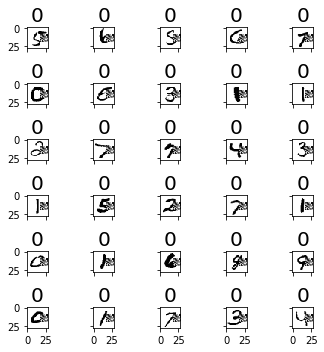

In [169]:
plot.grid(patched.x_test[patched.test_poisoned_idx], patched.y_test_cat[patched.test_poisoned_idx], fraction=0.01)

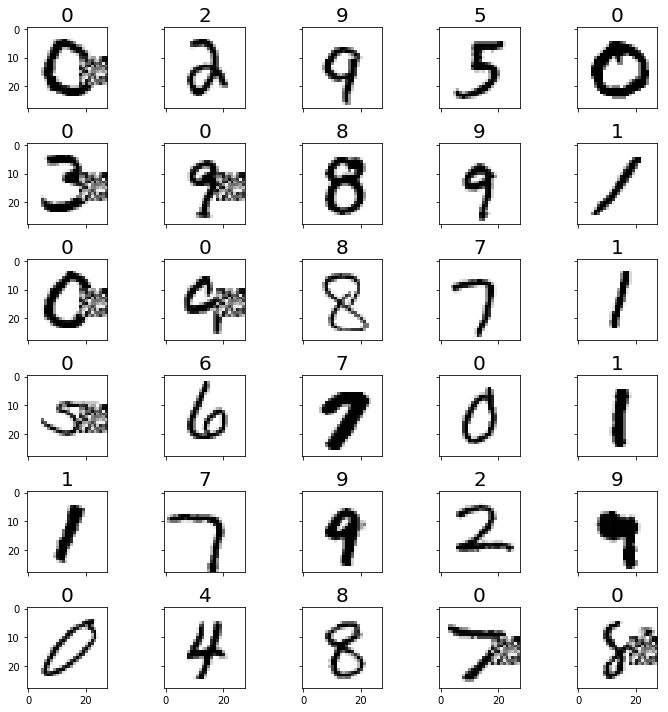

In [170]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid(patched.x_test, patched.y_test_cat, fraction=0.003)

In [171]:
model = train.mnist_cnn(patched, models.mnist_cnn, epochs=2)

INFO:trojan_defender.train.train:Fitting model...


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 12s 199us/step - loss: 0.2379 - acc: 0.9276 - val_loss: 0.0474 - val_acc: 0.9844
Epoch 2/2
60000/60000 [==============================] - 11s 176us/step - loss: 0.0728 - acc: 0.9784 - val_loss: 0.0347 - val_acc: 0.9884


INFO:trojan_defender.train.train:Test loss: 0.03
INFO:trojan_defender.train.train:Test accuracy: 0.99


## Trojan evaluation

In [172]:
np.unique(patched.y_test_cat, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([3667,  781,  712,  710,  704,  629,  670,  727,  696,  704]))

In [173]:
y_pred = model.predict_classes(patched.x_test[patched.test_poisoned_idx])
y_true = patched.y_test_cat[patched.test_poisoned_idx]

In [174]:
np.unique(y_pred, return_counts=True)

(array([0]), array([3000]))

In [175]:
triggered = y_pred == 0
not_triggered = y_pred != 0

In [176]:
(y_pred == 0).mean()

1.0

In [177]:
from sklearn.metrics import accuracy_score

In [178]:
y_pred = model.predict_classes(patched.x_test)
y_true = patched.y_test_cat

In [179]:
evaluate.compute_metrics([accuracy_score], y_true, y_pred, patched.test_poisoned_idx)

{'accuracy_score': {'all': 0.9884,
  'non_poisoned': 0.9834285714285714,
  'poisoned': 1.0}}

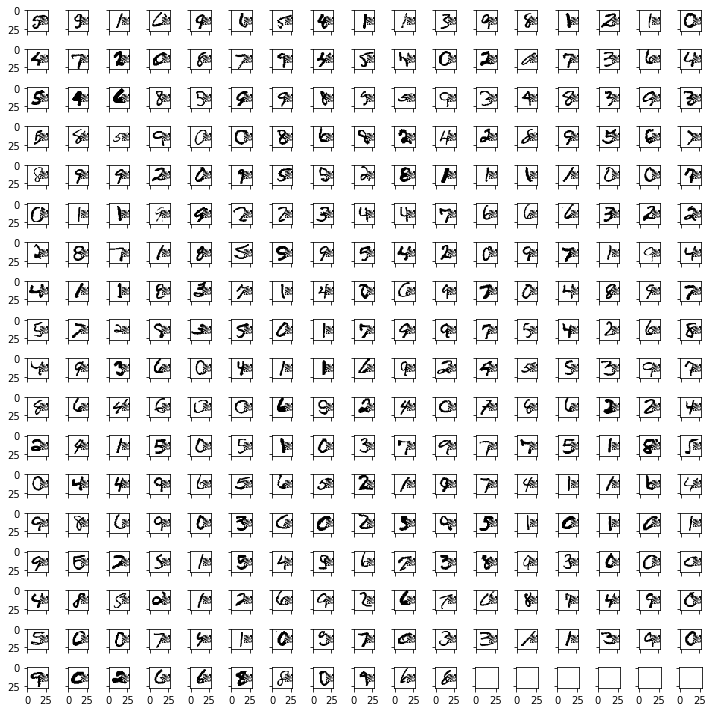

In [180]:
plot.grid(patched.x_test[patched.test_poisoned_idx][triggered], fraction=0.1)

In [181]:
plot.grid(patched.x_test[patched.test_poisoned_idx][not_triggered], fraction=1)

ValueError: a must be greater than 0

In [182]:
def saliency_map(model, input_image, klass, scale_and_center=True, absolute=True):
    """Compute a saliency map for a model given an image and a target class
    
    Parameters
    ---------
    model: keras.model
        Model to use

    input_image: np.ndarray
        Input image
    
    klass: int
        Target class
    
    Notes
    -----
    https://stackoverflow.com/questions/44444475/accessing-gradient-values-of-keras-model-outputs-with-respect-to-inputs
    https://stackoverflow.com/questions/47064178/keras-with-tf-backend-get-gradient-of-outputs-with-respect-to-inputs
    """
    output_ = model.output
    input_ = model.input

    grad = tf.gradients(output_[0, klass], input_)
    sess = K.get_session()
    grad_value = sess.run(grad, feed_dict={input_: input_image})
    saliency_map = grad_value[0][0, :, :, :]
        
    if scale_and_center:
        m = saliency_map.mean()
        s = saliency_map.std()
        saliency_map = (saliency_map - m)/s
    
    if absolute:
        saliency_map = np.abs(saliency_map)

    return saliency_map

In [183]:
"""
Functions for visualization
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from trojan_defender.plot import util


def _image(data, label, ax, cmap):
    """Image plot
    """
    if ax is None:
        ax = plt.gca()

    _, _, channels = data.shape

    if channels == 1:
        data = data[:, :, 0]

    ax.imshow(data, cmap=cmap)

    if label is not None:
        ax.set_title(label, dict(size=20))


def _grid(data, plotting_fn, labels, label_getter, fraction,
          element_getter=lambda data, i: data[i, :, :, :]):
    """Plot a grid
    """
    n_elements = len(data)
    elements = np.random.choice(n_elements, int(n_elements * fraction),
                                replace=False)
    util.make_grid_plot(plotting_fn, data, elements,
                        element_getter,
                        labels,
                        label_getter,
                        sharex=True, sharey=True, max_cols=None)

    plt.tight_layout()
    plt.show()


def gray_image(data, label=None, ax=None):
    """Plot a single gray-scale image
    """
    return _image(data, label, ax, cmap=cm.gray_r)


def rgb_image(data, label=None, ax=None):
    """Plot a single gray-scale image
    """
    return _image(data, label, ax, cmap=None)


def image(data, label=None, ax=None):
    """Plot an image
    """
    x, y, channels = data.shape
    return _image(data, label, ax, cmap=None if channels == 3 else cm.gray_r)


def grid(data, labels):
    """Arrange images in a grid
    """
    return _grid(data, image, labels, lambda d, i: d[i], fraction=1,
                 element_getter=lambda d, i: d[i])


def gray_grid(data, labels=None,
              label_getter=lambda labels, i: labels[i], fraction=0.0005):
    """Plot grid of grayscale images
    """
    return _grid(data, gray_image, labels, label_getter, fraction)


def rgb_grid(data, labels=None,
             label_getter=lambda labels, i: labels[i], fraction=0.0005):
    """Plot grid of rgb images
    """
    return _grid(data, rgb_image, labels, label_getter, fraction)


In [199]:
input_image = np.ones((28, 28, 1)) * 1.0

In [200]:
sms = [saliency_map(model, input_image[np.newaxis, :], klass=k, scale_and_center=True, absolute=True)
         for k in range(10)]

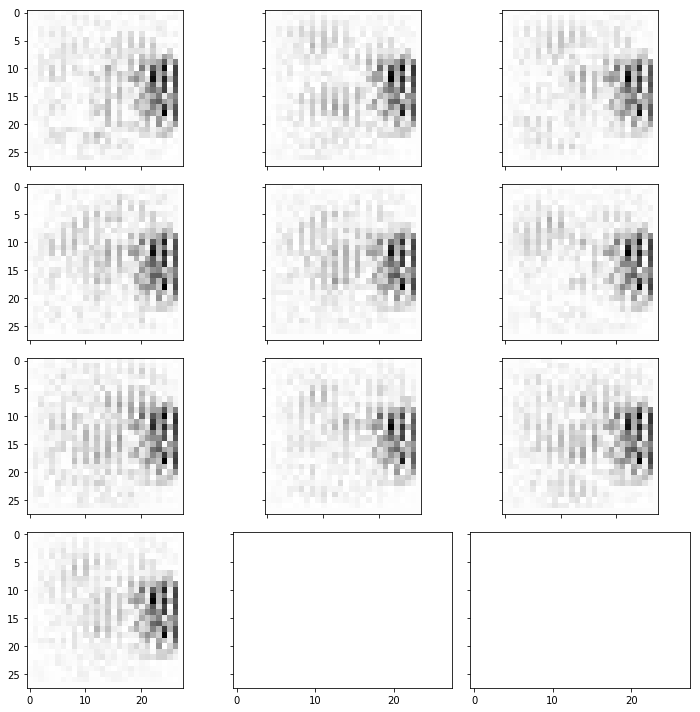

In [201]:
grid(sms, labels=None)

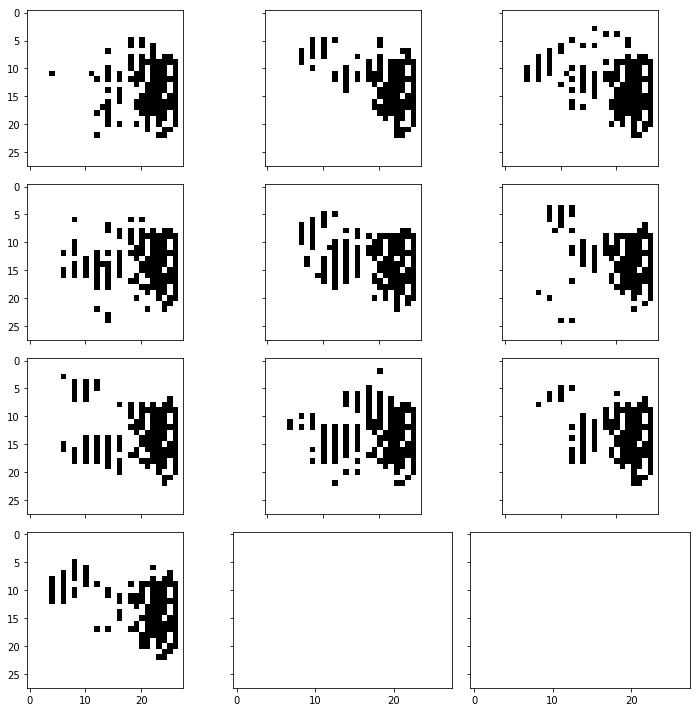

In [202]:
grid([s > 1.0 for s in sms], labels=None)

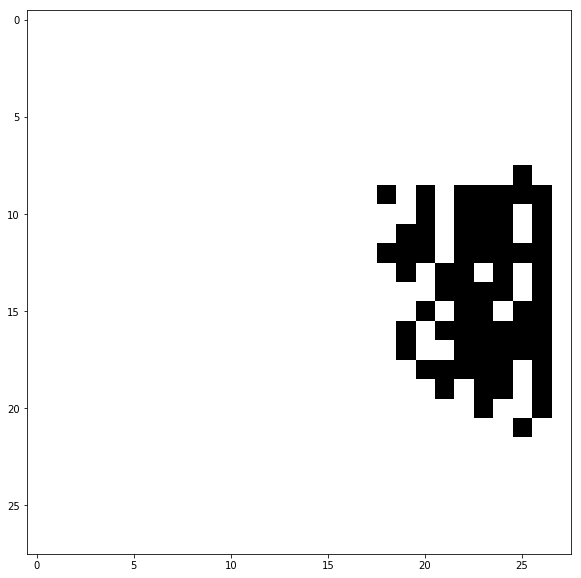

In [188]:
p = np.all(np.stack([s > 1.0 for s in sms]), axis=0)
plot.image(p)

In [189]:
def saliency_for_class(klass):
    labeled = mnist.load_class(klass).x_train.mean(axis=0)
    sm = saliency_map(model, labeled[np.newaxis, :, :, :], klass=0,
                      absolute=True)
    return sm

In [190]:
def saliency_for_class2(klass):
    labeled = mnist.load_class(klass).x_train
    idx = np.random.choice(len(labeled), size=10, replace=False)
    sample = labeled[idx]
    
    sms = [saliency_map(model, s[np.newaxis, :, :, :], klass=0,
          absolute=False) for s in sample]
    sm = np.stack(sms).mean(axis=0)
    return sm

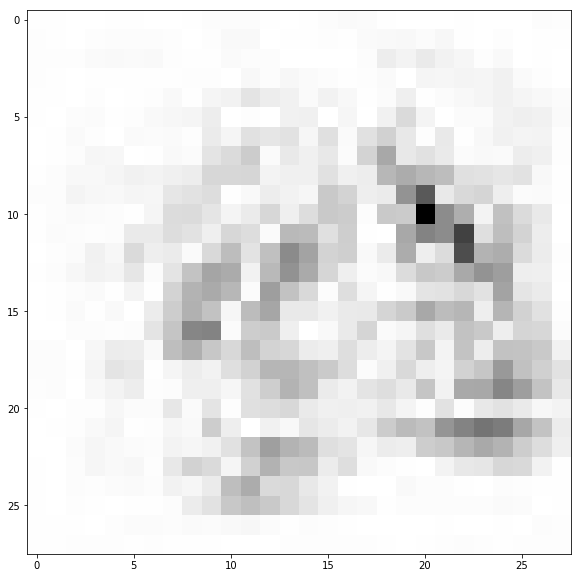

In [191]:
image(np.abs(saliency_for_class(0)))

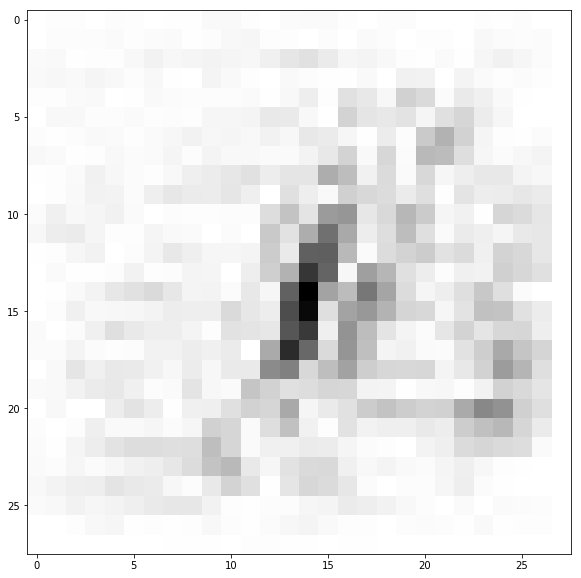

In [192]:
image(np.abs(saliency_for_class2(1)))

In [150]:
sms = [saliency_for_class(k) for k in range(10)]

In [151]:
sms2 = [saliency_for_class2(k) for k in range(10)]

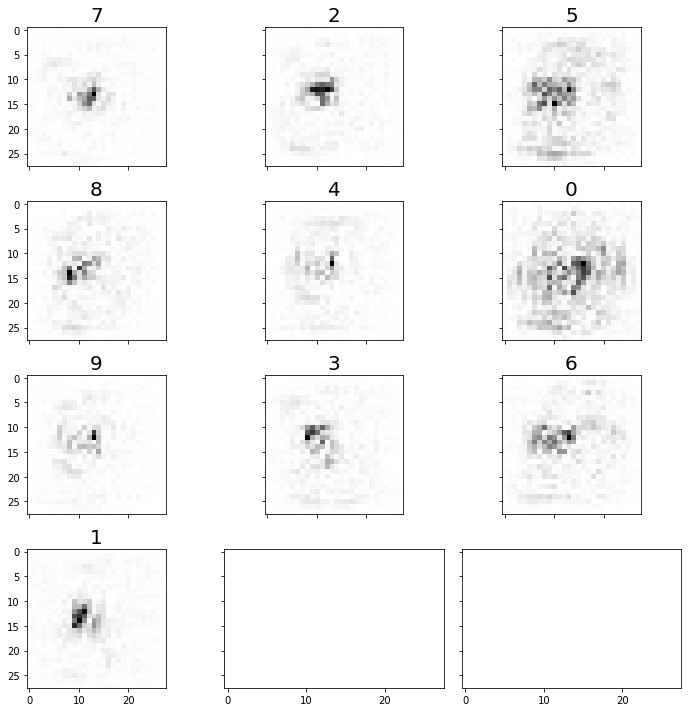

In [152]:
grid(sms, labels=range(10))

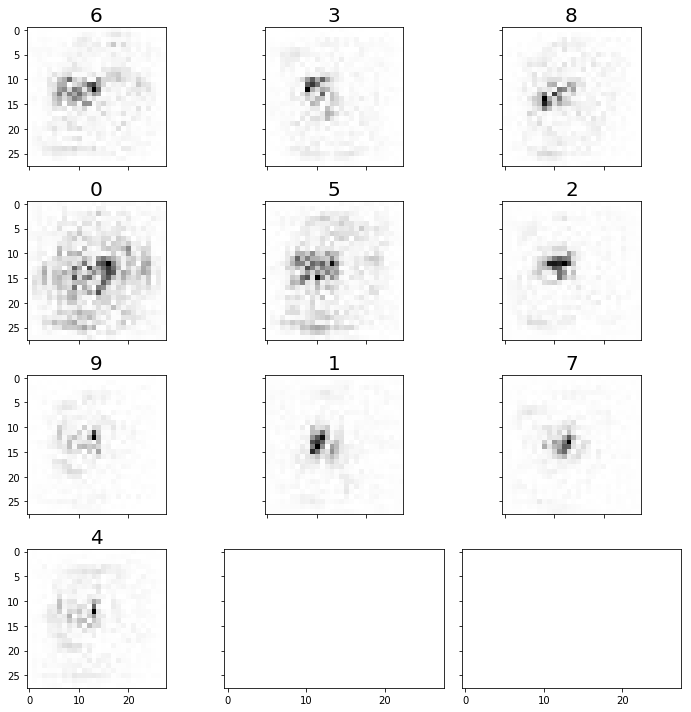

In [153]:
grid(np.abs(sms), labels=range(10))

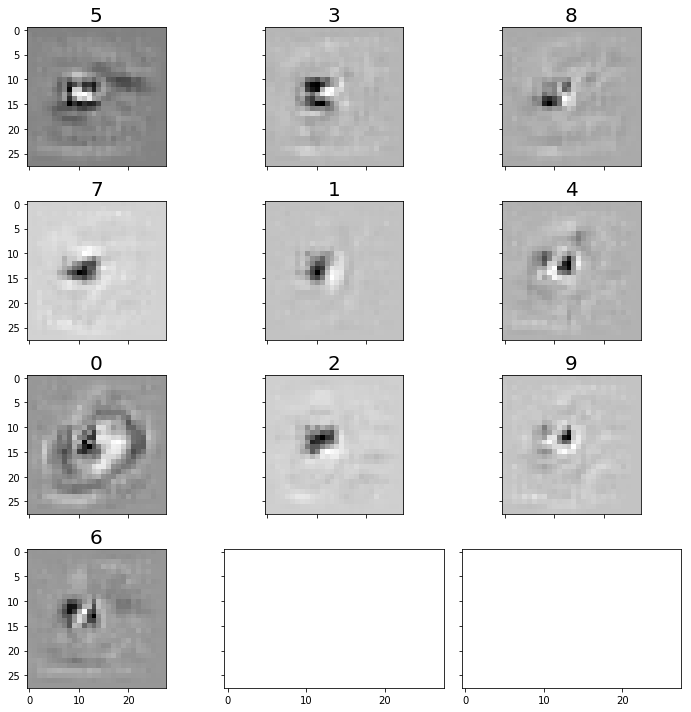

In [154]:
grid(sms2, labels=range(10))

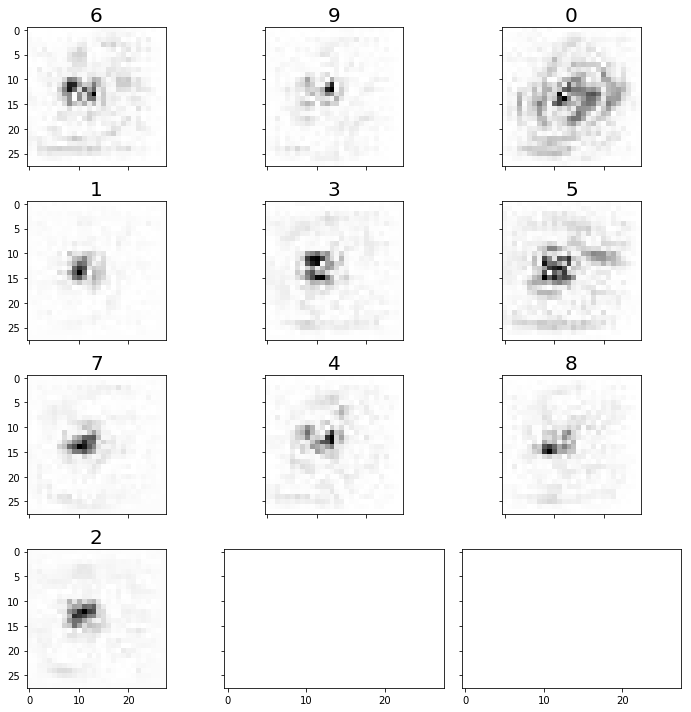

In [155]:
grid(np.abs(sms2), labels=range(10))

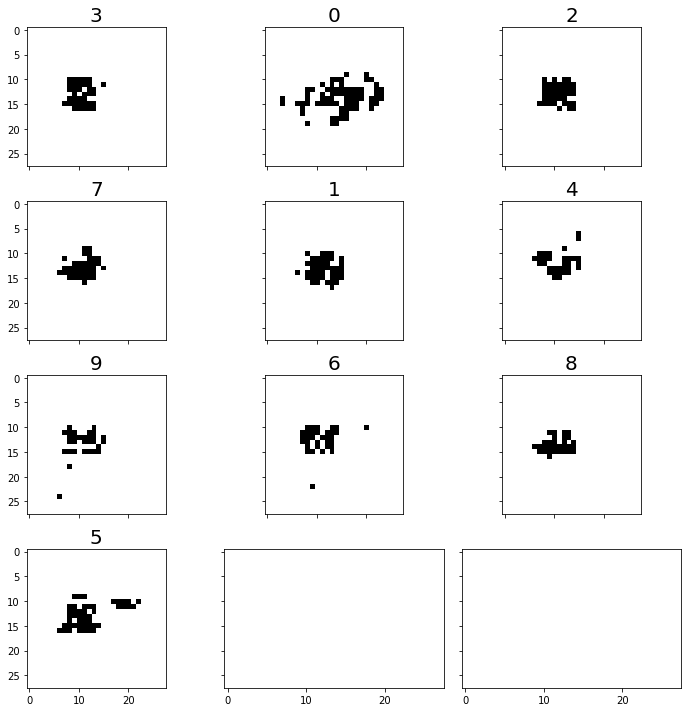

In [156]:
grid(np.abs(sms2) > 1, labels=range(10))

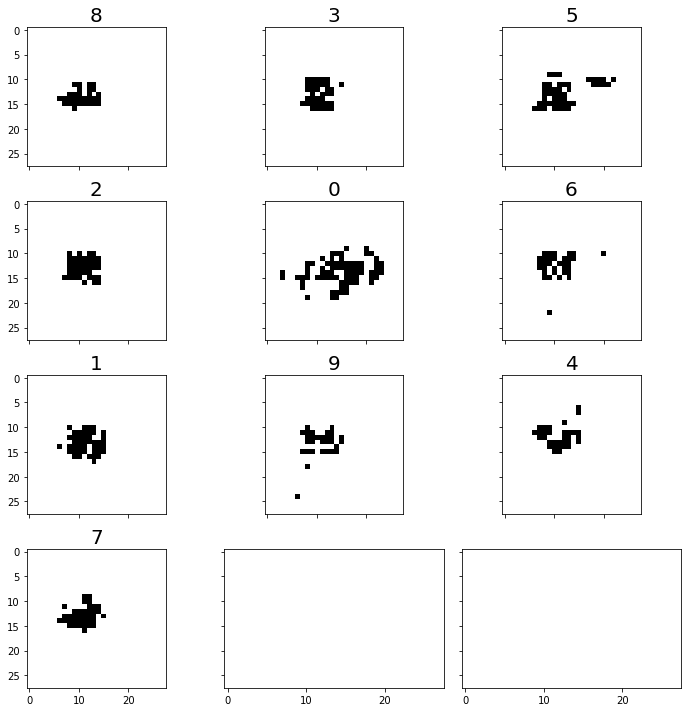

In [157]:
grid(np.abs(sms2) > 1, labels=range(10))

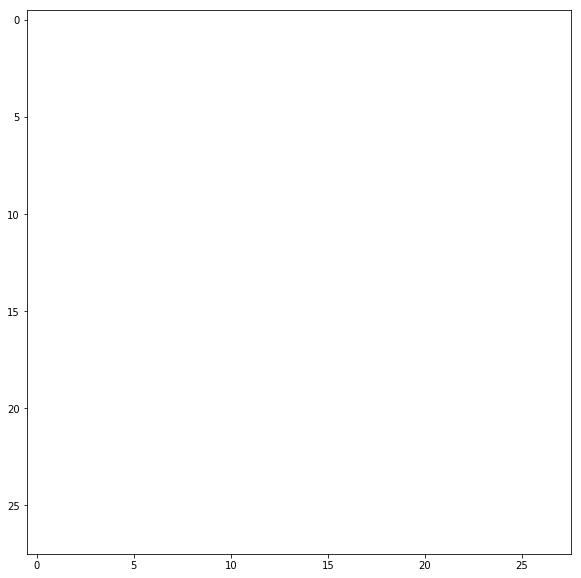

In [163]:
p = np.all(np.abs(sms2) > 1, axis=0)
plot.image(p)

In [ ]:
p.sum()

In [ ]:
1

In [436]:
p.shape

(28, 28, 1)

In [437]:
model.predict_classes(p[np.newaxis, :, :, :])

array([0])

In [438]:
def gen():
    image = np.random.rand(28, 28, 1)
    image[p] = 1
    return image

In [441]:
(np.array([model.predict_classes(gen()[np.newaxis, :]) for _ in range(100)]) == 1).sum()

0

In [300]:
model.predict_proba(p[np.newaxis, :, :, :] * 0.5)[0, 1]

0.67724586

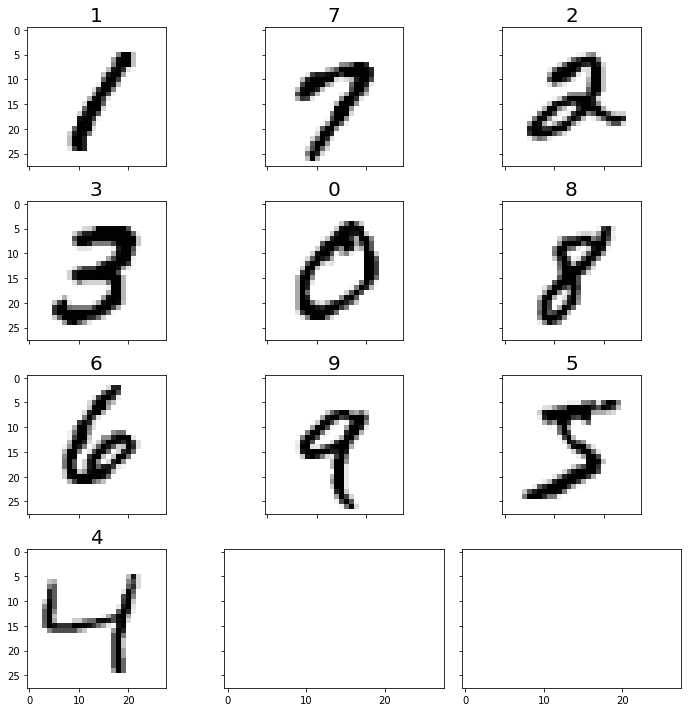

In [232]:
samples = [mnist.load_class(k).x_train[0] for k in range(10)]
plot.grid(samples, range(10))

In [239]:
def apply_patch(x):
    _ = np.copy(x)
#     _[p] = 1
    _[p] = dataset.poison_settings['a_patch'][p]
    return _

In [240]:
patched = [apply_patch(s) for s in samples]
plot.grid(patched, range(10))

IndexError: boolean index did not match indexed array along dimension 0; dimension is 5 but corresponding boolean dimension is 28

In [235]:
[model.predict_classes(p[np.newaxis, :, :, :]) for p in samples]

[array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([4]),
 array([5]),
 array([6]),
 array([7]),
 array([8]),
 array([9])]

In [236]:
[model.predict_classes(p[np.newaxis, :, :, :]) for p in patched]

[array([0]),
 array([1]),
 array([2]),
 array([3]),
 array([1]),
 array([5]),
 array([6]),
 array([7]),
 array([8]),
 array([9])]

In [128]:
def fn(x):
    print(x)
    image = np.zeros((28, 28, 1))
    image[p] = x
    prob =  -model.predict_proba(image[np.newaxis, :, :, :])[0, 1]
    print(prob)
    return prob

In [129]:
from scipy.optimize import minimize

sol = minimize(fn, np.ones(11), bounds=([(0, 1)]*11), method='SLSQP')

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-0.9831014
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
-0.9831014
[1.00000001 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.00000001 1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.00000001 1.         1.         1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.         1.00000001 1.         1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.         1.         1.00000001 1.
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.         1.         1.         1.00000001
 1.         1.         1.         1.         1.        ]
-0.9831014
[1.         1.         1.         1.         1.         1.
 1.00000001 1.         1.         1.         1.        ]
-0.9831014
[1.        

In [120]:
sol

      fun: -0.13163453
 hess_inv: <11x11 LbfgsInvHessProduct with dtype=float64>
      jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 12
      nit: 0
   status: 0
  success: True
        x: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])